In [1]:
from __future__ import absolute_import, division, print_function
import torch
import torch.nn as nn
import json
from trainer import train,eval
from cost import crit_weights_gen
from net import Net
from dataset import NerDataset, VOCAB, pad
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from resample import Resampling
import argparse
import csv
import json
import logging
import os
import random
import sys
import wandb
import math
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
from crf import CRF
from dataset import tokenizer, VOCAB, tag2idx, idx2tag
from sklearn.metrics import classification_report,f1_score

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AdamW, AutoTokenizer, AutoModel
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset, ConcatDataset)

/mldata/NER/ner_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import os
os.getcwd()

'/notebooks'

In [17]:
nas = NER_Adaptive_Resampling('/notebooks/NER_Adaptive_Resampling/train.txt',\
                              '/notebooks/NER_Adaptive_Resampling/train_output.txt')
x,y = nas.conll_data_read()

In [ ]:
y[:3]

In [12]:
labels = [label for item in y for label in item]
num_tokens = len(labels)
labels[:5]

['O', 'B-ORG', 'O', 'B-MISC', 'O']

In [15]:
ent = [label[2:] for label in labels if label != 'O']
count_ent = Counter(ent)
for key in count_ent:
    #Use frequency instead of count
    count_ent[key] = count_ent[key]/num_tokens
count_ent

Counter({'ORG': 0.049005949151133855,
         'MISC': 0.02245230169088856,
         'PER': 0.054397825651253624,
         'LOC': 0.040558838913412235})

In [6]:
trainset = "/mldata/NER/Resampling_mahtab/Bangla-NER-Splitted-Dataset.json"
with open(trainset) as infile:
    data = json.load(infile)

new = data['train']
train_texts, train_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))
new = data['validation']
valid_texts, valid_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))
new = data['test']
test_texts, test_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))

In [49]:
all_labels = [y for label in train_labels for y in label]
all_labels[:3]

['O', 'O', 'O']

In [51]:
{k:v/len(all_labels)*100 for k,v in dict(Counter(all_labels)).items()}

{'O': 80.76771853709792,
 'B-PER': 7.911624806516851,
 'I-PER': 2.3517382413087935,
 'B-OBJ': 1.0916403981516003,
 'B-ORG': 1.7720231840829745,
 'I-ORG': 0.961710108576529,
 'B-LOC': 4.240133771706832,
 'I-LOC': 0.8176569614389497,
 'I-OBJ': 0.08575399111954717}

In [16]:
nas = Resampling(train_texts,train_labels)
nas.get_stats()

Counter({'PER': 0.10263363047825645,
         'OBJ': 0.011773943892711476,
         'ORG': 0.027337332926595036,
         'LOC': 0.05057790733145782})

In [61]:
method = 'sCRD'
nas = Resampling(train_texts,train_labels)
sampled_sents, sampled_labels = nas.resamp(method)

In [62]:
all_labels = [y for label in sampled_labels for y in label]

In [63]:
{k:v/len(all_labels)*100 for k,v in dict(Counter(all_labels)).items()}

{'O': 68.33375791971544,
 'B-PER': 10.94737015912554,
 'I-PER': 4.224280679904326,
 'B-OBJ': 1.9041814682197096,
 'B-ORG': 3.2117011289280137,
 'I-ORG': 2.1293891617249527,
 'B-LOC': 7.208415302093211,
 'I-LOC': 1.8304980398262025,
 'I-OBJ': 0.21040614046261047}

In [7]:
method = 'bus'
nas = Resampling(train_texts,train_labels)
sampled_sents, sampled_labels = nas.BUS()

In [9]:
all_labels = [y for label in sampled_labels for y in label]
{k:v/len(all_labels)*100 for k,v in dict(collections.Counter(all_labels)).items()}

{'O': 62.11668354345866,
 'B-PER': 15.58414100837905,
 'I-PER': 4.632401215129025,
 'B-OBJ': 2.150288760056528,
 'B-ORG': 3.490491504111631,
 'I-ORG': 1.8943549912648694,
 'B-LOC': 8.352120355636664,
 'I-LOC': 1.6106023345610736,
 'I-OBJ': 0.1689162874024948}

In [11]:
from augment import get_category2mentions, get_label2tokens
from augment import generate_sentences_by_shuffle_within_segments, generate_sentences_by_replace_mention, generate_sentences_by_replace_token, generate_sentences_by_synonym_replacement
from aug_dataclass import ConllCorpus

In [12]:
corpus = ConllCorpus('development', trainset)
category2mentions = get_category2mentions(corpus.train)
label2tokens = get_label2tokens(corpus.train, 1)
print(f"# sentences before augmenting: {len(corpus.train)}")
# print(f"# sentences in development set: {len(corpus.dev)}")

train_data = corpus.train
replace_ratio = 0.3
num_generated_samples = 1
augmented_sentences = []
for s in train_data:
    
    augmented_sentences += generate_sentences_by_replace_mention(s, category2mentions, replace_ratio,
                                                                    num_generated_samples)
    
    augmented_sentences += generate_sentences_by_replace_token(s, label2tokens, replace_ratio,
                                                                num_generated_samples)
    
    augmented_sentences += generate_sentences_by_shuffle_within_segments(s, replace_ratio,
                                                                            num_generated_samples)
    
    augmented_sentences += generate_sentences_by_synonym_replacement(s, replace_ratio,
                                                                        num_generated_samples)
train_data += augmented_sentences

for sentence in train_data:
    train_texts.append([t.text for t in sentence.tokens])
    train_labels.append([t.get_label('gold') for t in sentence.tokens])

# sentences before augmenting: 64155


In [ ]:
all_labels = [y for label in train_labels for y in label]
{k:v/len(all_labels)*100 for k,v in dict(collections.Counter(all_labels)).items()}

# Error Analysis

In [2]:
with open('/mldata/NER/Resampling_mahtab/Bangla-NER-Splitted-Dataset.json') as infile:
    data = json.load(infile)
new = data['train']
train_texts, train_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))
new = data['validation']
valid_texts, valid_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))
new = data['test']
test_texts, test_labels = list(zip(*map(lambda d: (d['sentence'], d['iob_tags']), new)))
train_texts,train_labels = Resampling(train_texts, train_labels).resamp('nsCRD')
sents_train, tags_li_train = [], []
for x in train_texts:
    sents_train.append(["[CLS]"] + x + ["[SEP]"])
for y in train_labels:
    tags_li_train.append(["<PAD>"] + y + ["<PAD>"])

sents_valid, tags_li_valid = [], []
for x in valid_texts:
    sents_valid.append(["[CLS]"] + x + ["[SEP]"])
for y in valid_labels:
    tags_li_valid.append(["<PAD>"] + y + ["<PAD>"])

sents_test, tags_li_test = [], []
for x in test_texts:
    sents_test.append(["[CLS]"] + x + ["[SEP]"])
for y in test_labels:
    tags_li_test.append(["<PAD>"] + y + ["<PAD>"])


train_dataset = NerDataset(sents_train, tags_li_train)
eval_dataset = NerDataset(sents_valid, tags_li_valid)
test_dataset = NerDataset(sents_test, tags_li_test)

train_iter = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size= 128,
                                shuffle=True,
                                collate_fn=pad,
                                num_workers=0
                                )
eval_iter = torch.utils.data.DataLoader(dataset=eval_dataset,
                                batch_size=32,
                                shuffle=False,
                                collate_fn = pad,
                                num_workers=0
                                )
test_iter = torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=32,
                                shuffle=False,
                                collate_fn = pad,
                                num_workers=0
                                )

test_dataset[0]

('[CLS] ৫% তার চাইতে পশ্চিমোরে এর সাক্ষরতার হার কম [SEP]',
 [2, 274, 9, 826, 6130, 2376, 5545, 919, 13733, 1391, 1056, 3],
 [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 '<PAD> O O O B-LOC O O O O <PAD>',
 [0, 3, 0, 3, 3, 8, 0, 3, 3, 3, 3, 0],
 12)

In [4]:
import collections
train_sents = [' '.join(sent)+' '.join(tags) for sent,tags in zip(sents_train,tags_li_train)]
most_common = sorted(collections.Counter(train_sents).items(),\
                    key = lambda x:x[1],reverse=True)
#analyzing top 15 most common sentences and their tags
m_sent,m_tags = [sent[0].split('<PAD>')[0] for sent in most_common[:15]],\
    [tag[0].split('<PAD>')[1][:-1] for tag in most_common[:15]]

m_sent,m_tags

(['[CLS] সারা ভারতের সাক্ষরতার হার ৫৯ [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৪% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৩% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৫% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১২% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৬% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৭% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১১% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৮% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১০% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৮% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৭% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৯% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৫% হল ৬ বছর বা তার কম বয়সী [SEP]',
  '[CLS] এই শহরের জনসংখ্যার ১৬% হল ৬ বছর বা তার কম বয়সী [SEP]'],
 [' O B-LOC O O O',
  ' O B-LOC O O O O O O

In [5]:
most_common

[('[CLS] সারা ভারতের সাক্ষরতার হার ৫৯ [SEP]<PAD> O B-LOC O O O <PAD>', 2289),
 ('[CLS] এই শহরের জনসংখ্যার ১৪% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  178),
 ('[CLS] এই শহরের জনসংখ্যার ১৩% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  164),
 ('[CLS] এই শহরের জনসংখ্যার ১৫% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  160),
 ('[CLS] এই শহরের জনসংখ্যার ১২% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  148),
 ('[CLS] এই শহরের জনসংখ্যার ১৬% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  114),
 ('[CLS] এই শহরের জনসংখ্যার ১৭% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  82),
 ('[CLS] এই শহরের জনসংখ্যার ১১% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  74),
 ('[CLS] এই শহরের জনসংখ্যার ১৮% হল ৬ বছর বা তার কম বয়সী [SEP]<PAD> O B-LOC O O O O O O O O O <PAD>',
  66),
 ('[CLS] এই শহরের জনসংখ্যার ১০% হল ৬ বছর বা ত

In [ ]:
sent,tags = m_sent.split()[1:-1],m_tags.split()
sen_len = len(tags)
rsp_time = 1
ents = collections.Counter([label[2:] for label in tags if label != 'O'])
method='nsCRD'
    # Pass if there's no entity in a sentence
if ents:
    for ent in ents.keys():
        # Resampling method selection and resampling time calculation, 
        # see section 'Resampling Functions' in our paper for details.
        if method == 'sc':
            rsp_time += ents[ent]
        if method == 'sCR' or method == 'sCRD':
            weight = -log(stats[ent],2)
            rsp_time += ents[ent]*weight
        if method == 'nsCRD':
            weight = -log(stats[ent],2)
            rsp_time += sqrt(ents[ent])*weight
    if method == 'sCR':
        rsp_time = sqrt(rsp_time)
    if method == 'sCRD' or method == 'nsCRD':
        rsp_time = rsp_time/sqrt(sen_len)
    # Ceiling to ensure the integrity of resamling time
    rsp_time = ceil(rsp_time) 

In [3]:
from dataset import NerDataset, VOCAB, pad
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nscrd_model = Net(True, len(VOCAB), device, True)
model_path = '/mldata/NER/Resampling_mahtab/sen_model_output_nsCRD/model.pt'
checkpoint = torch.load(model_path)
nscrd_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
base_model = Net(True, len(VOCAB), device, True)
model_path = '/mldata/NER/Resampling_mahtab/banner_model/model.pt'
checkpoint = torch.load(model_path)
base_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [58]:
base_model.to(device).eval()

Words, Is_heads, Tags, Y, Y_hat, Y_hat_viterbi = [], [], [], [], [], []


crf = CRF(len(VOCAB))
crf.to(device='cuda' if torch.cuda.is_available() else 'cpu')

#loss_list= []

with torch.no_grad():
    for i, batch in enumerate(test_iter):
        words, x, is_heads, tags, y, seqlens = batch

        logits_focal, logits_crf, y_, y_hat = base_model(x, y)

        Words.extend(words)
        Is_heads.extend(is_heads)
        Tags.extend(tags)
        Y.extend(y.numpy().tolist())
        Y_hat.extend(y_hat.cpu().numpy().tolist())
        

all_preds = []
result_dir = os.path.join('/mldata/NER/Resampling_mahtab',"val_results.txt")
with open(result_dir, 'w') as fout:
    for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
        y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
        preds = [idx2tag[hat] for hat in y_hat]
        all_preds.append(preds)
        for x in range(len(preds)):
              if preds[x] == '<PAD>':
                preds[x] = 'O'
        assert len(preds)==len(words.split())==len(tags.split()), "Sentence: {}\n True Tags: {}\n Pred Tags: {}".format(words,tags,preds)
        for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
            fout.write("{} {} {}\n".format(w,t,p))
        fout.write("\n")

y_true =  np.array([tag2idx[line.split()[1]] for line in open(result_dir, 'r').read().splitlines() if len(line) > 0])
y_pred =  np.array([tag2idx[line.split()[2]] for line in open(result_dir, 'r').read().splitlines() if len(line) > 0])


report = classification_report(y_true,y_pred, labels = [1,2,3,4,5,6,7,8,9], digits=4, zero_division=0)
f1_macro = f1_score(y_true,y_pred, labels = [1,2,3,4,5,6,7,8,9], average = 'macro')
print(report)

              precision    recall  f1-score   support

           1     0.6583    0.6639    0.6611       357
           2     0.5726    0.4994    0.5335       853
           3     0.9565    0.9488    0.9526     39499
           4     0.2553    0.4211    0.3179        57
           5     0.8112    0.8185    0.8148      1223
           6     0.4762    0.4538    0.4647       573
           7     0.5720    0.5853    0.5785       516
           8     0.7934    0.7796    0.7864      2005
           9     0.7578    0.8384    0.7961      4035

    accuracy                         0.9095     49118
   macro avg     0.6504    0.6676    0.6562     49118
weighted avg     0.9106    0.9095    0.9098     49118



## nscrd method vs base banner method

In [59]:
predictions_df = pd.DataFrame({'sentences':[item[0] for item in test_dataset]})
predictions_df.head(5)

,sentences
0,[CLS] ৫% তার চাইতে পশ্চিমোরে এর সাক্ষরতার হার ...
1,[CLS] গত ২০১৫ সালের ৫ আগস্ট সকাল সাড়ে ৮টার দিক...
2,[CLS] জেলা ক্রীড়া সংস্থার সাধারণ সম্পাদক ওবায়দ...
3,[CLS] আমার ছবি তুলে আর কী হবে [SEP]
4,[CLS] ডেভিড ওলিয়ারি জন্ম মে ২ ২০০৮ লন্ডনে একজ...


In [61]:
from collections import defaultdict

def make_preds_df(df,model,model_name,test_iter,device):

    model.to(device).eval()
    Is_heads, Tags, Y, Y_hat, Y_hat_viterbi = [], [], [], [], []
    crf = CRF(len(VOCAB))
    crf.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    #loss_list= []

    with torch.no_grad():
        for i, batch in enumerate(test_iter):
            words, x, is_heads, tags, y, seqlens = batch
            logits_focal, logits_crf, y_, y_hat = model(x, y)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    all_preds = []
    all_mistakes = []
    all_tags = []
    for is_heads, tags, y_hat in zip(Is_heads, Tags, Y_hat):
        y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
        preds = [idx2tag[hat] for hat in y_hat]
        for x in range(len(preds)):
            if preds[x] == '<PAD>':
                preds[x] = 'O'
        assert len(preds)==len(tags.split()), "True Tags: {}\n Pred Tags: {}".format(tags,preds)
        mistakes = defaultdict(list)
        tags = tags.split()[1:-1]
        preds = preds[1:-1]
        for correct,predicted in zip(tags,preds):
            if correct!=predicted:
                mistakes[correct].append(predicted) 
        all_preds.append(preds)
        all_mistakes.append(mistakes)
        all_tags.append(tags)
    df[model_name+'_preds'] = all_preds
    df[model_name+'_mistakes'] = all_mistakes
    if 'tags' not in df.columns:
        df['tags'] = all_tags
    return df
        

In [62]:
pred_df = make_preds_df(predictions_df,nscrd_model,'nsCRD',test_iter,'cuda')
pred_df.head()

,sentences,nsCRD_preds,nsCRD_mistakes,tags
0,[CLS] ৫% তার চাইতে পশ্চিমোরে এর সাক্ষরতার হার ...,"[O, O, O, B-LOC, O, O, O, O]",{},"[O, O, O, B-LOC, O, O, O, O]"
1,[CLS] গত ২০১৫ সালের ৫ আগস্ট সকাল সাড়ে ৮টার দিক...,"[O, O, O, O, O, O, O, O, O, B-LOC, O, B-PER, I...",{'O': ['B-LOC']},"[O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER..."
2,[CLS] জেলা ক্রীড়া সংস্থার সাধারণ সম্পাদক ওবায়দ...,"[O, B-ORG, I-ORG, O, O, B-PER, I-PER, I-PER]","{'B-LOC': ['O'], 'B-PER': ['B-ORG'], 'I-PER': ...","[B-LOC, B-PER, I-PER, I-PER, I-PER, B-PER, I-P..."
3,[CLS] আমার ছবি তুলে আর কী হবে [SEP],"[B-PER, B-OBJ, O, O, O, O]",{'O': ['B-OBJ']},"[B-PER, O, O, O, O, O]"
4,[CLS] ডেভিড ওলিয়ারি জন্ম মে ২ ২০০৮ লন্ডনে একজ...,"[B-PER, I-PER, O, O, O, O, B-LOC, O, B-LOC, O,...",{},"[B-PER, I-PER, O, O, O, O, B-LOC, O, B-LOC, O,..."


In [63]:
pred_df = make_preds_df(predictions_df,base_model,'banner',test_iter,'cuda')
pred_df.head()

,sentences,nsCRD_preds,nsCRD_mistakes,tags,banner_preds,banner_mistakes
0,[CLS] ৫% তার চাইতে পশ্চিমোরে এর সাক্ষরতার হার ...,"[O, O, O, B-LOC, O, O, O, O]",{},"[O, O, O, B-LOC, O, O, O, O]","[O, O, O, B-LOC, O, O, O, O]",{}
1,[CLS] গত ২০১৫ সালের ৫ আগস্ট সকাল সাড়ে ৮টার দিক...,"[O, O, O, O, O, O, O, O, O, B-LOC, O, B-PER, I...",{'O': ['B-LOC']},"[O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER...","[O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER...",{}
2,[CLS] জেলা ক্রীড়া সংস্থার সাধারণ সম্পাদক ওবায়দ...,"[O, B-ORG, I-ORG, O, O, B-PER, I-PER, I-PER]","{'B-LOC': ['O'], 'B-PER': ['B-ORG'], 'I-PER': ...","[B-LOC, B-PER, I-PER, I-PER, I-PER, B-PER, I-P...","[O, B-ORG, I-ORG, B-PER, I-PER, B-PER, I-PER, ...","{'B-LOC': ['O'], 'B-PER': ['B-ORG'], 'I-PER': ..."
3,[CLS] আমার ছবি তুলে আর কী হবে [SEP],"[B-PER, B-OBJ, O, O, O, O]",{'O': ['B-OBJ']},"[B-PER, O, O, O, O, O]","[B-PER, B-OBJ, O, O, O, O]",{'O': ['B-OBJ']}
4,[CLS] ডেভিড ওলিয়ারি জন্ম মে ২ ২০০৮ লন্ডনে একজ...,"[B-PER, I-PER, O, O, O, O, B-LOC, O, B-LOC, O,...",{},"[B-PER, I-PER, O, O, O, O, B-LOC, O, B-LOC, O,...","[B-PER, I-PER, O, O, O, O, B-LOC, O, B-LOC, O,...",{}


Confusion matrix

In [65]:
nsCRD_preds = [val for tags in pred_df['nsCRD_preds'] for val in tags]
banner_preds = [val for tags in pred_df['banner_preds'] for val in tags]
true_labels = [val for tags in pred_df['tags'] for val in tags]

In [71]:
assert(len(nsCRD_preds) == len(true_labels) and len(banner_preds) == len(true_labels))

In [72]:
len(true_labels)

49118

In [66]:
set(nsCRD_preds),set(true_labels),set(banner_preds)

({'B-LOC', 'B-OBJ', 'B-ORG', 'B-PER', 'I-LOC', 'I-OBJ', 'I-ORG', 'I-PER', 'O'},
 {'B-LOC', 'B-OBJ', 'B-ORG', 'B-PER', 'I-LOC', 'I-OBJ', 'I-ORG', 'I-PER', 'O'},
 {'B-LOC', 'B-OBJ', 'B-ORG', 'B-PER', 'I-LOC', 'I-OBJ', 'I-ORG', 'I-PER', 'O'})

nscrd classification report

In [67]:
labels = ['I-LOC', 'B-ORG', 'O', 'I-OBJ', 'I-PER', 'B-OBJ', 'I-ORG', 'B-LOC', 'B-PER']
nscrd_report = classification_report(true_labels,nsCRD_preds,\
                labels = labels, digits=4, zero_division=0)
print(nscrd_report)

              precision    recall  f1-score   support

       I-LOC     0.6575    0.6667    0.6620       357
       B-ORG     0.5244    0.5029    0.5135       853
           O     0.9544    0.9431    0.9488     39499
       I-OBJ     0.2593    0.1228    0.1667        57
       I-PER     0.7866    0.8168    0.8014      1223
       B-OBJ     0.4320    0.4433    0.4376       573
       I-ORG     0.5356    0.5388    0.5372       516
       B-LOC     0.7523    0.7636    0.7579      2005
       B-PER     0.7440    0.8238    0.7818      4035

    accuracy                         0.9022     49118
   macro avg     0.6273    0.6246    0.6230     49118
weighted avg     0.9038    0.9022    0.9028     49118



banner classification report

In [88]:
nscrd_report = classification_report(true_labels,banner_preds,\
                labels = labels, digits=4, zero_division=0)
print(nscrd_report)

              precision    recall  f1-score   support

       I-LOC     0.6583    0.6639    0.6611       357
       B-ORG     0.5726    0.4994    0.5335       853
           O     0.9565    0.9488    0.9526     39499
       I-OBJ     0.2553    0.4211    0.3179        57
       I-PER     0.8112    0.8185    0.8148      1223
       B-OBJ     0.4762    0.4538    0.4647       573
       I-ORG     0.5720    0.5853    0.5785       516
       B-LOC     0.7934    0.7796    0.7864      2005
       B-PER     0.7578    0.8384    0.7961      4035

    accuracy                         0.9095     49118
   macro avg     0.6504    0.6676    0.6562     49118
weighted avg     0.9106    0.9095    0.9098     49118



In [85]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def confusion_matrix_visual(y_true, y_pred, class_labels, normalize=False,
                            flip=False, ax=None, title=None, **kwargs):
    """
    Create a confusion matrix heatmap to evaluate classification.
    Parameters:
        - y_test: The true values for y
        - preds: The predicted values for y
        - class_labels: What to label the classes.
        - normalize: Whether to plot the values as percentages.
        - flip: Whether to flip the confusion matrix. This is helpful to get
                TP in the top left corner and TN in the bottom right when dealing
                with binary classification with labels True and False.
        - ax: The matplotlib `Axes` object to plot on.
        - title: The title for the confusion matrix
        - kwargs: Additional keyword arguments for `seaborn.heatmap()`
    Returns:
        A matplotlib `Axes` object.
    """
    mat = confusion_matrix(y_true, y_pred,labels = class_labels)
    if normalize:
        fmt, mat = '.2%', mat / mat.sum()
    else:
        fmt = 'd'

    if flip:
        class_labels = class_labels[::-1]
        mat = np.flip(mat)

    axes = sns.heatmap(
        mat, square=True, annot=True, fmt=fmt,
        cbar=True, cmap=plt.cm.Blues, ax=ax, **kwargs
    )
    axes.set(xlabel='Model Prediction', ylabel='Actual Label')
    tick_marks = np.arange(len(class_labels)) + 0.5
    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels,rotation=30)
    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels, rotation=30)
    axes.set_title(title or 'Confusion Matrix')
    return axes

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Model Prediction', ylabel='Actual Label'>

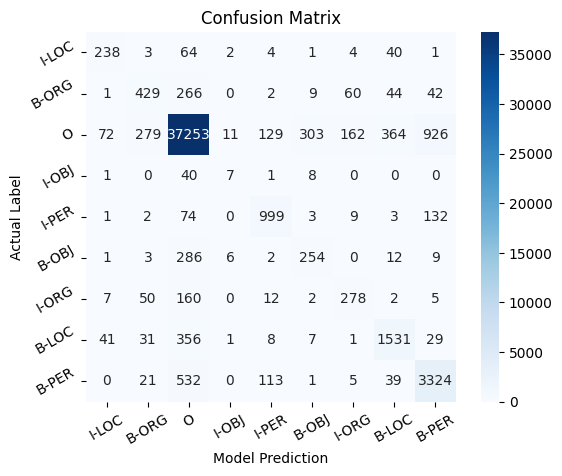

In [86]:
confusion_matrix_visual(true_labels,nsCRD_preds,class_labels=labels)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Model Prediction', ylabel='Actual Label'>

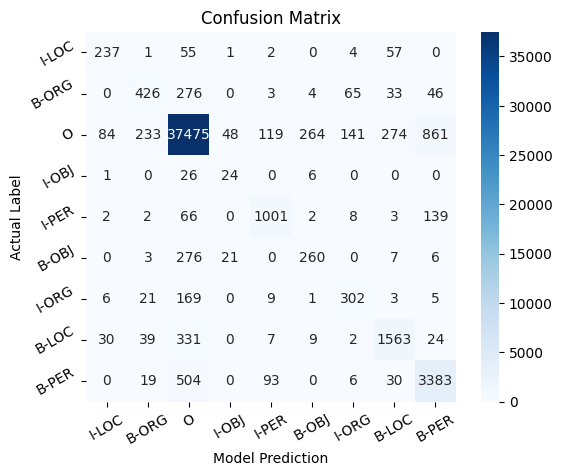

In [87]:
confusion_matrix_visual(true_labels,banner_preds,class_labels=labels)

4 worst performing tags for all models are - B-OBJ, I-OBJ, B-ORG, I-ORG. Performing error analysis on these tags to see if sentence sampling does anything to improve performance on these tags - F1 score suggests performance decreases. Elaborating on that.

common mistakes between banner and nscrd banner

In [23]:
common_bobj = pred_df.loc[pred_df['banner_mistakes'].\
            apply(lambda x:'B-OBJ' in x) & pred_df['nsCRD_mistakes'].apply(lambda x:'B-OBJ' in x),:]

common_iobj = pred_df.loc[pred_df['banner_mistakes'].\
            apply(lambda x:'I-OBJ' in x) & pred_df['nsCRD_mistakes'].apply(lambda x:'I-OBJ' in x),:]

common_borg = pred_df.loc[pred_df['banner_mistakes'].\
            apply(lambda x:'B-ORG' in x) & pred_df['nsCRD_mistakes'].apply(lambda x:'B-ORG' in x),:]

common_iorg = pred_df.loc[pred_df['banner_mistakes'].\
            apply(lambda x:'I-ORG' in x) & pred_df['nsCRD_mistakes'].apply(lambda x:'I-ORG' in x),:]

common_iorg.head()

,sentences,nsCRD_preds,nsCRD_mistakes,tags,banner_preds,banner_mistakes
6,[CLS] এই ফ্লাইটটি পরিচালনা করে ব্রিটিশ ইউরোপীয...,"[<PAD>, O, O, O, O, B-LOC, I-LOC, I-LOC, O, B-...","{'B-OBJ': ['O'], 'B-ORG': ['B-LOC'], 'I-ORG': ...","[<PAD>, O, B-OBJ, O, O, B-ORG, I-ORG, I-ORG, O...","[<PAD>, O, O, O, O, O, O, O, O, O, O, O, O, O,...","{'B-OBJ': ['O'], 'B-ORG': ['O'], 'I-ORG': ['O'..."
7,[CLS] টুর্নামেন্টে নিজেদের প্রথম ম্যাচে উরুগুয়...,"[<PAD>, O, O, O, O, B-LOC, O, O, O, O, O, O, O...","{'B-ORG': ['B-LOC'], 'I-ORG': ['O']}","[<PAD>, O, O, O, O, B-LOC, O, O, O, O, O, O, O...","[<PAD>, O, O, O, O, B-LOC, O, O, O, O, O, O, O...","{'B-ORG': ['B-LOC'], 'I-ORG': ['O']}"
38,[CLS] অন্য শিপ ব্রেকিং ইয়ার্ডও অনুপ্রাণিত হবে ...,"[<PAD>, O, O, O, O, O, O, O, O, O, O, O, O, B-...","{'B-ORG': ['O', 'O'], 'I-ORG': ['O', 'O', 'O',...","[<PAD>, O, B-ORG, I-ORG, I-ORG, O, O, O, O, O,...","[<PAD>, O, O, O, O, O, O, O, O, O, B-ORG, I-OR...","{'B-ORG': ['O'], 'I-ORG': ['O', 'O']}"
95,[CLS] দক্ষিণ সুরমা থানার ভারপ্রাপ্ত কর্মকর্তা ...,"[<PAD>, B-LOC, I-LOC, O, B-PER, I-PER, <PAD>]","{'B-ORG': ['B-LOC'], 'I-ORG': ['I-LOC', 'O']}","[<PAD>, B-ORG, I-ORG, I-ORG, B-PER, I-PER, <PAD>]","[<PAD>, B-LOC, I-LOC, I-LOC, B-PER, I-PER, <PAD>]","{'B-ORG': ['B-LOC'], 'I-ORG': ['I-LOC', 'I-LOC']}"
116,[CLS] চীনে নুওসু ভাষাটিকে বৃহত্তর ই yi ভাষা-পর...,"[<PAD>, B-LOC, O, O, O, O, O, O, O, O, O, O, O...",{'I-ORG': ['O']},"[<PAD>, B-LOC, O, O, O, O, O, O, O, O, O, O, O...","[<PAD>, B-LOC, O, O, O, O, O, O, O, O, O, O, O...",{'I-ORG': ['B-ORG']}


In [24]:
common_bobj.shape,common_iobj.shape,common_borg.shape,common_iorg.shape

((185, 6), (26, 6), (264, 6), (115, 6))

newly made mistakes by nscrd banner that base banner did not make

In [25]:
def com_func(df,col_name,tag_name,contains=True):
    if not contains:
        return df.loc[df[col_name].apply(lambda x:tag_name not in x),:]
    return df.loc[df[col_name].apply(lambda x:tag_name in x),:]

new_bobj = pred_df.pipe(com_func,'nsCRD_mistakes','B-OBJ').pipe(com_func,'banner_mistakes','B-OBJ',False)
new_iobj = pred_df.pipe(com_func,'nsCRD_mistakes','I-OBJ').pipe(com_func,'banner_mistakes','I-OBJ',False)
new_borg = pred_df.pipe(com_func,'nsCRD_mistakes','B-ORG').pipe(com_func,'banner_mistakes','B-ORG',False)
new_iorg = pred_df.pipe(com_func,'nsCRD_mistakes','I-ORG').pipe(com_func,'banner_mistakes','I-ORG',False)

new_bobj.head()

,sentences,nsCRD_preds,nsCRD_mistakes,tags,banner_preds,banner_mistakes
90,[CLS] দারোগাহাটের ওজন স্কেল পরিচালনার জন্য বেস...,"[<PAD>, B-LOC, O, O, O, O, O, O, O, O, O, O, O...","{'B-OBJ': ['O'], 'I-OBJ': ['O'], 'B-ORG': ['O'...","[<PAD>, B-LOC, B-OBJ, I-OBJ, O, O, B-ORG, B-OR...","[<PAD>, B-LOC, B-OBJ, I-OBJ, O, O, B-ORG, I-OR...","{'B-ORG': ['I-ORG', 'B-PER']}"
113,[CLS] তাদের ১৯৯৫ সালে প্রকাশিত প্রথম অ্যালবাম ...,"[<PAD>, B-PER, O, O, O, O, O, O, O, O, O, O, O...","{'B-OBJ': ['O'], 'I-OBJ': ['B-OBJ']}","[<PAD>, B-PER, O, O, O, O, O, O, O, O, O, O, O...","[<PAD>, B-PER, O, O, O, O, O, O, O, O, O, O, O...",{}
267,[CLS] গ্রিন্ডকোরকে বৈশিষ্ট্যমন্ডিত করা যায় উচ...,"[<PAD>, O, O, O, O, O, O, O, O, O, O, O, O, O,...","{'B-OBJ': ['O'], 'B-PER': ['O']}","[<PAD>, O, O, O, O, O, O, O, O, B-OBJ, O, O, O...","[<PAD>, O, O, O, O, O, O, O, O, B-OBJ, O, O, O...",{'B-PER': ['O']}
381,[CLS] ভ্যানডেম আজই মাইক্রোফিল্ম নিয়ে মাউন্ট র...,"[<PAD>, B-PER, O, O, O, B-LOC, I-LOC, O, O, O,...","{'B-OBJ': ['O'], 'O': ['B-OBJ'], 'B-LOC': ['O']}","[<PAD>, B-PER, O, B-OBJ, O, B-LOC, I-LOC, O, O...","[<PAD>, B-PER, O, B-OBJ, O, B-LOC, I-LOC, O, O...","{'O': ['B-OBJ'], 'B-LOC': ['O']}"
662,[CLS] দেশে খাবার বড়ি ও কনডমের ব্যবহার বেশি [SEP],"[<PAD>, B-LOC, B-OBJ, O, O, O, O, O, <PAD>]","{'I-OBJ': ['O'], 'B-OBJ': ['O']}","[<PAD>, B-LOC, B-OBJ, I-OBJ, O, B-OBJ, O, O, <...","[<PAD>, B-LOC, B-OBJ, O, O, B-OBJ, O, O, <PAD>]",{'I-OBJ': ['O']}


In [26]:
new_bobj.shape,new_iobj.shape,new_borg.shape,new_iorg.shape

((30, 6), (11, 6), (56, 6), (42, 6))

mistakes base banner made but nscrd banner did not

In [27]:
cor_bobj = pred_df.pipe(com_func,'banner_mistakes','B-OBJ').pipe(com_func,'nsCRD_mistakes','B-OBJ',False)
cor_iobj = pred_df.pipe(com_func,'banner_mistakes','I-OBJ').pipe(com_func,'nsCRD_mistakes','I-OBJ',False)
cor_borg = pred_df.pipe(com_func,'banner_mistakes','B-ORG').pipe(com_func,'nsCRD_mistakes','B-ORG',False)
cor_iorg = pred_df.pipe(com_func,'banner_mistakes','I-ORG').pipe(com_func,'nsCRD_mistakes','I-ORG',False)

cor_bobj.head()

,sentences,nsCRD_preds,nsCRD_mistakes,tags,banner_preds,banner_mistakes
8,[CLS] তাদের ক্রমবর্ধমান ক্ষমতা ও ধনসম্পদের পরি...,"[<PAD>, B-PER, O, O, O, B-OBJ, O, O, O, B-PER,...","{'B-LOC': ['O', 'O'], 'I-LOC': ['B-OBJ', 'I-OB...","[<PAD>, B-PER, O, O, O, B-OBJ, O, O, O, B-PER,...","[<PAD>, B-PER, O, O, O, O, O, O, O, B-PER, O, ...","{'B-OBJ': ['O'], 'B-LOC': ['O', 'B-PER', 'O'],..."
12,[CLS] নিখোঁজের কয়েক মাস পূর্বেও পিন্টুর কাছ থে...,"[<PAD>, O, O, O, O, B-PER, O, O, O, B-OBJ, O, ...","{'B-PER': ['O', 'O']}","[<PAD>, B-PER, O, O, O, B-PER, O, O, O, B-OBJ,...","[<PAD>, O, O, O, O, B-PER, O, O, O, B-OBJ, O, ...","{'B-PER': ['O'], 'O': ['B-OBJ'], 'B-OBJ': ['I-..."
126,[CLS] আগামী ২০ আগস্টের মধ্যে শূন্য তালিকা পাঠা...,"[<PAD>, O, O, O, O, O, O, O, O, B-PER, O, B-OB...",{},"[<PAD>, O, O, O, O, O, O, O, O, B-PER, O, B-OB...","[<PAD>, O, O, O, O, O, O, O, O, B-PER, O, O, O...",{'B-OBJ': ['O']}
155,[CLS] ২৬ নভেম্বর ১৬১০ সালে নিকোলাস ক্লদ ফাবরি ...,"[<PAD>, O, O, O, O, B-PER, I-PER, I-PER, O, O,...",{'B-LOC': ['O']},"[<PAD>, O, O, O, O, B-PER, I-PER, I-PER, O, O,...","[<PAD>, O, O, O, O, B-PER, I-PER, I-PER, O, O,...","{'B-LOC': ['O'], 'B-OBJ': ['O']}"
246,[CLS] আমি নিজেও কোনো সম্পদ ধরি না [SEP],"[<PAD>, B-PER, B-PER, O, B-OBJ, O, O, <PAD>]",{},"[<PAD>, B-PER, B-PER, O, B-OBJ, O, O, <PAD>]","[<PAD>, B-PER, O, O, O, O, O, <PAD>]","{'B-PER': ['O'], 'B-OBJ': ['O']}"


In [28]:
cor_bobj.shape,cor_iobj.shape,cor_borg.shape,cor_iorg.shape

((41, 6), (0, 6), (66, 6), (21, 6))

# Data Augmentation